Captum은 모델 해석을 위한 Pytorch 라이브러리입니다.

Captum은 크게 3가지 부류의 알고리즘을 제공합니다.
 
- **Primary Attribution** : Evaluates contribution of each input feature to the output of a model.
- **Layer Attribution** : Evaluates contribution of each neuron in a given layer to the output of the model.
- **Neuron Attribution** : Evaluates contribution of each input feature on the activation of a particular hidden neuron.

간단하게 설명하면 input 단위 / layer 단위 / activation 단위라고 볼 수 있겠네요.

## Import library & Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import os

CIFAR10 데이터셋을 사용해서 튜토리얼을 진행한다.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


원본 튜토리얼에는 gpu를 사용하지 않는 것 같으니 gpu를 사용해보자.

In [3]:
CUDA = torch.cuda.is_available()

## Model

기본적인 네트워크를 설계한다.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

if CUDA:
    net = net.cuda()

## Train

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/cifar_torchvision.pt'))
else:
    for epoch in range(1, 6):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 1):
            # get the inputs
            inputs, labels = data
            if CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 0:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    os.makedirs('./models', exist_ok=True)
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

Using existing trained model


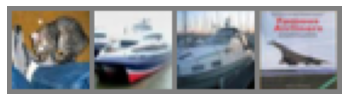

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [7]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if CUDA:
    outputs = net(images.cuda()).cpu()
else:
    outputs = net(images)
    
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [20]:
ind = 3

input = images[ind].unsqueeze(0)

if CUDA:
    input = input.cuda()

input.requires_grad = True

In [21]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [22]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
        

### Original Image

Original Image
Predicted: ship  Probability: 0.9191474318504333


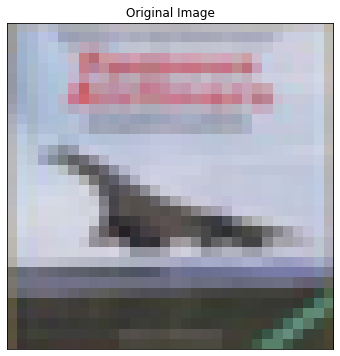

In [23]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

### Saliency Maps

> Original paper : [
Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)

In [24]:
saliency = Saliency(net)
grads = saliency.attribute(input.cuda(), 
                           target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
print(grads.shape)

(32, 32, 3)


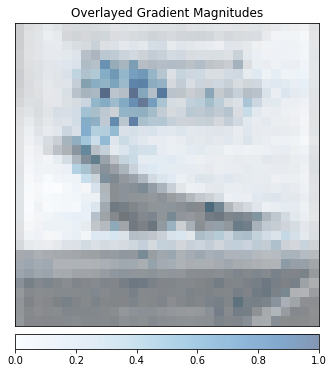

In [25]:
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

### Intergrated Gradients

> original paper : [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)

In [26]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, 
                                          input, 
                                          baselines=(input * 0)
                                          , return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))
print(attr_ig.shape)

Approximation delta:  tensor([0.0770], device='cuda:0', dtype=torch.float64)
(32, 32, 3)


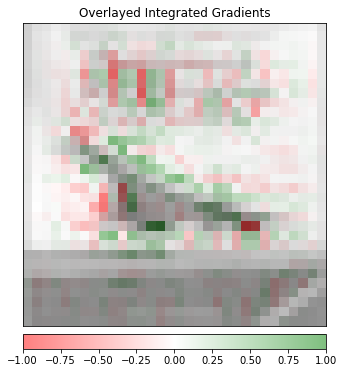

In [27]:
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")



### Intergradient Gradient with SmoothGrad

In [28]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)

attr_ig_nt = attribute_image_features(nt, 
                                      input,
                                      baselines=(input * 0), 
                                      nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)

attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

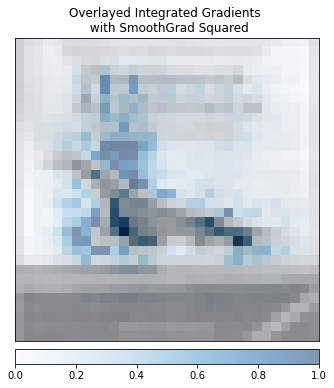

In [29]:
_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")



### DeepLift

> Original paper : [Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1704.02685)

In [30]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, 
                                   input,
                                   baselines=(input * 0))
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

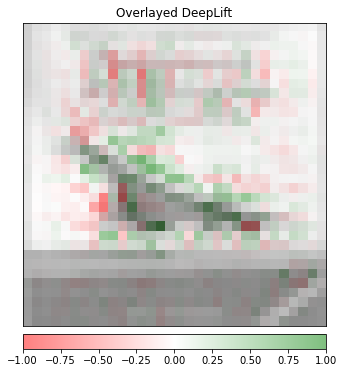

In [31]:
_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")